# Supervised machine learning project: classification models for movies

This project uses the Kaggle dataset [Movies (IMDb, Earnings and more)](https://www.kaggle.com/datasets/delfinaoliva/movies).

We build classifiers to address the question: given a set of paramters of a movie, such as its length (running time), genre, budget, etc., will it win any Oscar and Golden Globes awards?

In [75]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.kernel_approximation import Nystroem
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, precision_recall_fscore_support, precision_score, recall_score, roc_auc_score
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler

from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings

warnings.filterwarnings('ignore')

## 1. Data loading, preprocessing, and exploration

Load the data and sort by chronological sequence.

In [76]:
df_raw = pd.read_csv('movies_data.csv', encoding='ISO-8859-1')
df_raw = df_raw.sort_values(by = 'Release year', ascending = True)
df_raw.head()

,Movie,Director,Running time,Actor 1,Actor 2,Actor 3,Genre,Budget,Box Office,Actors Box Office %,Director Box Office %,Earnings,Oscar and Golden Globes nominations,Oscar and Golden Globes awards,Release year,IMDb score
3471,The Broadway Melody,Harry Beaumont,100,Anita Page,Bessie Love,Charles King,Romance,379000,40000000,100.0,100.0,39621000,4,3.0,1929,6.3
2654,Hell's Angels,Howard Hughes,96,Jean Harlow,Marian Marsh,James Hall,Drama,3950000,8500000,100.0,100.0,4550000,1,0.0,1930,7.8
3272,She Done Him Wrong,Lowell Sherman,66,Mae West,Gilbert Roland,Louise Beavers,Comedy,200000,2000000,100.0,100.0,1800000,1,0.0,1933,6.5
2000,42nd Street,Lloyd Bacon,89,Ginger Rogers,Dick Powell,George Brent,Comedy,439000,2500000,100.0,100.0,2061000,2,2.0,1933,7.7
1843,It Happened One Night,Frank Capra,65,Claudette Colbert,Alan Hale,Walter Connolly,Comedy,325000,3500000,100.0,60.0,3175000,5,5.0,1934,8.2


In [77]:
df_raw.shape

(3974, 16)

In [78]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3974 entries, 3471 to 0
Data columns (total 16 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Movie                                3974 non-null   object 
 1   Director                             3974 non-null   object 
 2   Running time                         3974 non-null   int64  
 3   Actor 1                              3974 non-null   object 
 4   Actor 2                              3974 non-null   object 
 5   Actor 3                              3972 non-null   object 
 6   Genre                                3974 non-null   object 
 7   Budget                               3974 non-null   int64  
 8   Box Office                           3974 non-null   int64  
 9   Actors Box Office %                  3974 non-null   float64
 10  Director Box Office %                3974 non-null   float64
 11  Earnings                      

In [79]:
df_raw.isnull().sum()

Movie                                  0
Director                               0
Running time                           0
Actor 1                                0
Actor 2                                0
Actor 3                                2
Genre                                  0
Budget                                 0
Box Office                             0
Actors Box Office %                    0
Director Box Office %                  0
Earnings                               0
Oscar and Golden Globes nominations    0
Oscar and Golden Globes awards         3
Release year                           0
IMDb score                             0
dtype: int64

### 1.1 Drop the column ['movie']

We first drop the column containing movie names, assuming the names don't affect movies' award-winning chance as much as other factors in the dataset. A practical reason of dropping this column is if we were to keep it, then encoding the names uniquely to numerical values would create too many extra features to model.

In [80]:
df_raw_drop_movie = df_raw.drop(columns=['Movie'])
df_raw_drop_movie.head()

,Director,Running time,Actor 1,Actor 2,Actor 3,Genre,Budget,Box Office,Actors Box Office %,Director Box Office %,Earnings,Oscar and Golden Globes nominations,Oscar and Golden Globes awards,Release year,IMDb score
3471,Harry Beaumont,100,Anita Page,Bessie Love,Charles King,Romance,379000,40000000,100.0,100.0,39621000,4,3.0,1929,6.3
2654,Howard Hughes,96,Jean Harlow,Marian Marsh,James Hall,Drama,3950000,8500000,100.0,100.0,4550000,1,0.0,1930,7.8
3272,Lowell Sherman,66,Mae West,Gilbert Roland,Louise Beavers,Comedy,200000,2000000,100.0,100.0,1800000,1,0.0,1933,6.5
2000,Lloyd Bacon,89,Ginger Rogers,Dick Powell,George Brent,Comedy,439000,2500000,100.0,100.0,2061000,2,2.0,1933,7.7
1843,Frank Capra,65,Claudette Colbert,Alan Hale,Walter Connolly,Comedy,325000,3500000,100.0,60.0,3175000,5,5.0,1934,8.2


### 1.2 Combine ['Director', 'Actor 1', 'Actor 2', 'Actor 3'] columns and encode its effect

Four columns in the dataset, ['Director', 'Actor 1', 'Actor 2', 'Actor 3'], relate to the movie crew, which should correlate to a movie's performance. We combine the four columns into one and check whether any of the crew members won any previous awards. Apart from the assumed correlation, a practical reason of doing so is also to avoid creating too many extra columns.

In [81]:
#len(df['Director'].unique()), len(df['Actor 1'].unique())

In [82]:
def count_occurrence(df, old_col):
    count_list = []
    for i in range(len(df)):
        previous_values = df.iloc[:i].values.flatten()
        count = sum(previous_values.tolist().count(item) for item in df.loc[i, old_col])
        count_list.append(count)
    return count_list

In [83]:
df_raw_drop_movie['Director and Actor Prev Occ'] = count_occurrence(df_raw_drop_movie, ['Director', 'Actor 1', 'Actor 2', 'Actor 3'])

In [84]:
df_raw_drop_movie_crew = df_raw_drop_movie.drop(columns = ['Director', 'Actor 1', 'Actor 2', 'Actor 3'])
df_raw_drop_movie_crew

,Running time,Genre,Budget,Box Office,Actors Box Office %,Director Box Office %,Earnings,Oscar and Golden Globes nominations,Oscar and Golden Globes awards,Release year,IMDb score,Director and Actor Prev Occ
3471,100,Romance,379000,40000000,100.00,100.00,39621000,4,3.0,1929,6.3,0
2654,96,Drama,3950000,8500000,100.00,100.00,4550000,1,0.0,1930,7.8,0
3272,66,Comedy,200000,2000000,100.00,100.00,1800000,1,0.0,1933,6.5,0
2000,89,Comedy,439000,2500000,100.00,100.00,2061000,2,2.0,1933,7.7,0
1843,65,Comedy,325000,3500000,100.00,60.00,3175000,5,5.0,1934,8.2,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1682,116,Action,144000000,229000000,0.00,40.00,85000000,2,1.0,2016,5.5,4
545,95,Action,145000000,521000000,88.17,100.00,376000000,0,0.0,2016,7.2,17
1681,116,Action,144000000,229000000,0.00,40.00,85000000,2,0.0,2016,5.5,14
3855,96,Drama,8700000,1600000,0.00,0.00,-7100000,0,0.0,2016,7.2,47


In [85]:
df_raw_drop_movie_crew.describe()

,Running time,Budget,Box Office,Actors Box Office %,Director Box Office %,Earnings,Oscar and Golden Globes nominations,Oscar and Golden Globes awards,Release year,IMDb score,Director and Actor Prev Occ
count,3974.000000,3.974000e+03,3.974000e+03,3.974000e+03,3974.000000,3.974000e+03,3974.000000,3971.000000,3974.000000,3974.000000,3974.000000
mean,109.967036,3.690639e+07,1.086770e+08,2.984678e+09,52.780695,7.177060e+07,1.106694,0.321330,2002.043785,6.467866,12.595622
std,22.507658,4.270431e+07,1.798354e+08,1.344684e+11,35.360199,1.526573e+08,2.724019,1.209324,12.127027,1.072514,13.231117
min,20.000000,1.100000e+03,5.000000e+04,0.000000e+00,0.000000,-3.231000e+08,0.000000,0.000000,1929.000000,1.600000,0.000000
25%,95.000000,9.000000e+06,1.200000e+07,3.333000e+01,25.000000,0.000000e+00,0.000000,0.000000,1998.000000,5.900000,2.000000
50%,106.000000,2.200000e+07,4.300000e+07,5.714000e+01,50.000000,1.850000e+07,0.000000,0.000000,2005.000000,6.600000,9.000000
75%,120.000000,5.000000e+07,1.250000e+08,8.333000e+01,80.000000,8.100000e+07,1.000000,0.000000,2010.000000,7.200000,18.000000
max,330.000000,3.900000e+08,2.923000e+09,6.805556e+12,100.000000,2.686000e+09,22.000000,13.000000,2016.000000,9.300000,120.000000


### 1.3 Label encode ['Genre']

In [86]:
df_raw_drop_movie_crew['Genre'] = LabelEncoder().fit_transform(df_raw_drop_movie_crew['Genre'])

### 1.4 Drop rows with missing/invalid values

In [87]:
df_raw_drop_movie_crew.isnull().sum()

Running time                           0
Genre                                  0
Budget                                 0
Box Office                             0
Actors Box Office %                    0
Director Box Office %                  0
Earnings                               0
Oscar and Golden Globes nominations    0
Oscar and Golden Globes awards         3
Release year                           0
IMDb score                             0
Director and Actor Prev Occ            0
dtype: int64

In [88]:
df_raw_drop_movie_crew_dropna = df_raw_drop_movie_crew.dropna()
df_raw_drop_movie_crew_dropna.isnull().any()

Running time                           False
Genre                                  False
Budget                                 False
Box Office                             False
Actors Box Office %                    False
Director Box Office %                  False
Earnings                               False
Oscar and Golden Globes nominations    False
Oscar and Golden Globes awards         False
Release year                           False
IMDb score                             False
Director and Actor Prev Occ            False
dtype: bool

### 1.5 Check distribution of award winning movies

The distribution is extremely skewed, i.e., the vast majority of movies in the dataset win no award.

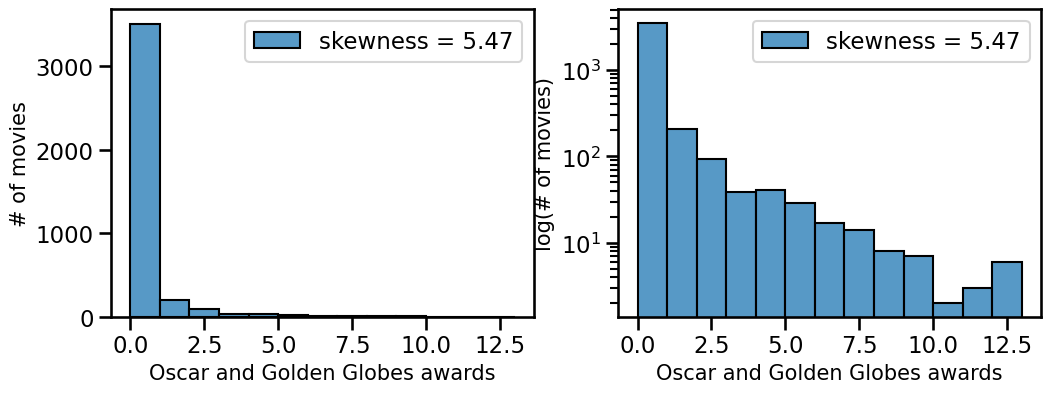

In [89]:
target_column = 'Oscar and Golden Globes awards'
y = df_raw_drop_movie_crew_dropna[target_column]
y_skew = stats.skew(y)

plt.figure(figsize = (12, 4))
plt.subplot(121)
sns.histplot(y, label = 'skewness = {:.2f}'.format(y_skew))
plt.xlabel(target_column, fontsize = 15)
plt.ylabel('# of movies', fontsize = 15)
plt.legend()
plt.subplot(122)
sns.histplot(y, label = 'skewness = {:.2f}'.format(y_skew))
plt.semilogy()
plt.xlabel(target_column, fontsize = 15)
plt.ylabel('log(# of movies)', fontsize = 15)
plt.legend()
#plt.savefig('distribution_multiclass_skewed.pdf', dpi = 200, bbox_inches = 'tight', pad_inches = 0.0)
plt.show()

### 1.6 Reduce multiple classes down to two classes: movies winning 0 and at least 1 award

To classify whether a movie would win any award at all, we encode all movies winning at least one award to be 1 in the target column. This also makes the dataset less imbalanced.

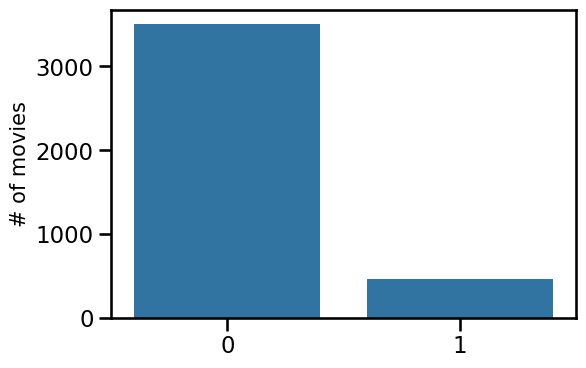

In [90]:
y = [1 if i > 0 else 0 for i in y]
df = df_raw_drop_movie_crew_dropna
plt.figure(figsize = (6, 4))
sns.barplot(x = [0, 1], y = [y.count(0), y.count(1)])
plt.ylabel('# of movies', fontsize = 15)
#plt.savefig('distribution_binary_unbalanced.pdf', dpi = 200, bbox_inches = 'tight', pad_inches = 0.0)
plt.show()

## 2. Balance the dataset

### 2.1 Train-test split

In [91]:
y = df[target_column]
y = np.array([1 if i > 0 else 0 for i in y])
x = df.drop(columns=[target_column])
feature_column = list(x.columns)
x = MinMaxScaler().fit_transform(x)

rs = 42
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, stratify = y, random_state = rs)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((3176, 11), (795, 11), (3176,), (795,))

### 2.2 SMOTE oversampling, random undersampling, class-reweighting

(5604, 11) (5604,)
(748, 11) (748,)


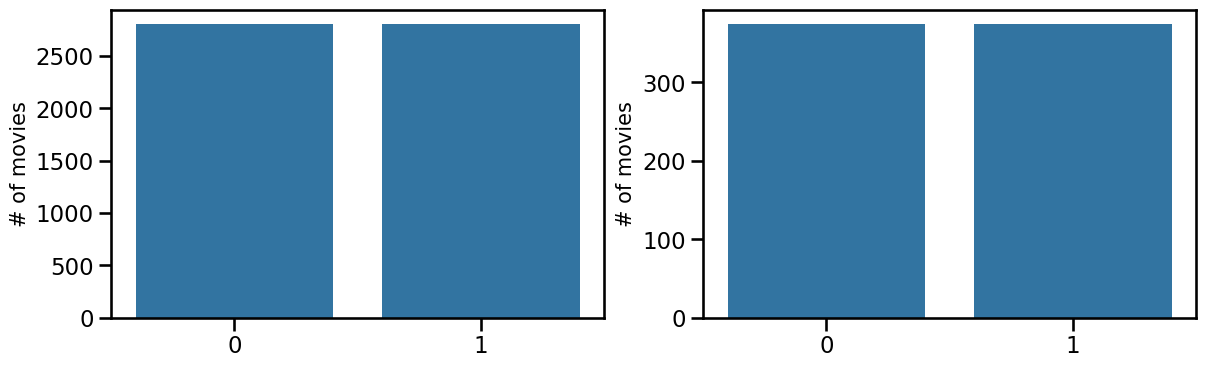

In [92]:
x_smo, y_smo = SMOTE(random_state = rs).fit_resample(x_train, y_train)
x_und, y_und = RandomUnderSampler(random_state = rs).fit_resample(x_train, y_train)
print(x_smo.shape, y_smo.shape)
print(x_und.shape, y_und.shape)

plt.figure(figsize = (14, 4))
plt.subplot(121)
sns.barplot(x = np.unique(y_smo, return_counts = True)[0], y = np.unique(y_smo, return_counts = True)[1])
plt.ylabel('# of movies', fontsize = 15)
plt.subplot(122)
sns.barplot(x = np.unique(y_und, return_counts = True)[0], y = np.unique(y_und, return_counts = True)[1])
plt.ylabel('# of movies', fontsize = 15)
#plt.savefig('distribution_binary_balanced.pdf', dpi = 200, bbox_inches = 'tight', pad_inches = 0.0)
plt.show()

Logistic regression (unweighted)

Logistic regression (unweighted) results: Accuracy = 0.957, Precision = 0.954, Recall = 0.667, F score = 0.785, AUC = 0.831.


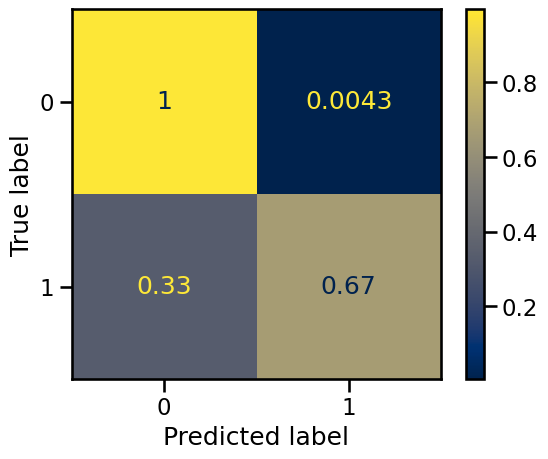

In [94]:
lr = LogisticRegression(random_state = rs, class_weight = None)
lr.fit(x_train, y_train)
lr_preds = lr.predict(x_test)

accuracy = accuracy_score(y_test, lr_preds)
precision, recall, f_beta, support = precision_recall_fscore_support(y_test, lr_preds, beta = 1, pos_label = 1, average = 'binary')
auc = roc_auc_score(y_test, lr_preds)
print('Logistic regression (unweighted) results: \
Accuracy = {:.3f}, Precision = {:.3f}, Recall = {:.3f}, F score = {:.3f}, AUC = {:.3f}.'.format(accuracy, precision, recall, f_beta, auc))

sns.set_context('talk')
ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test, lr_preds, normalize = 'true'),
                       display_labels = lr.classes_).plot(cmap = 'cividis')
#plt.savefig('confusion_lr_unweight.pdf', dpi = 200, bbox_inches = 'tight', pad_inches = 0.0)
plt.show()

table1_data = [['Unweighted', accuracy, precision, recall, f_beta, auc]]
table1 = pd.DataFrame(table1_data, columns = ['model', 'accuracy', 'precision', 'recall', 'f score', 'auc'])

Logistic regression with class-reweighting

Logistic regression (reweighted) results: Accuracy = 0.958, Precision = 0.958, Recall = 0.958, F score = 0.958, AUC = 0.897.


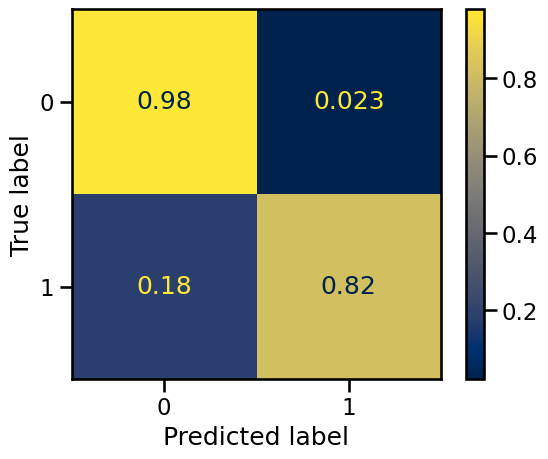

In [96]:
class_weight = {}
class_weight[0], class_weight[1] = 0.2, 0.8
lr = LogisticRegression(random_state = rs, class_weight = class_weight)
lr.fit(x_train, y_train)
lr_preds = lr.predict(x_test)

accuracy = accuracy_score(y_test, lr_preds)
precision, recall, f_beta, support = precision_recall_fscore_support(y_test, lr_preds, beta = 5, pos_label = 1, average = 'weighted')
auc = roc_auc_score(y_test, lr_preds)
print('Logistic regression (reweighted) results: \
Accuracy = {:.3f}, Precision = {:.3f}, Recall = {:.3f}, F score = {:.3f}, AUC = {:.3f}.'.format(accuracy, precision, recall, f_beta, auc))

sns.set_context('talk')
ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test, lr_preds, normalize = 'true'),
                       display_labels = lr.classes_).plot(cmap = 'cividis')
#plt.savefig('confusion_lr_reweight.pdf', dpi = 200, bbox_inches = 'tight', pad_inches = 0.0)
plt.show()

new_index = len(table1)
table1.loc[new_index] = ['Weighted', accuracy, precision, recall, f_beta, auc]

Logistic regression (SMOTE) results: Accuracy = 0.845, Precision = 0.431, Recall = 1.000, F score = 0.602, AUC = 0.912.


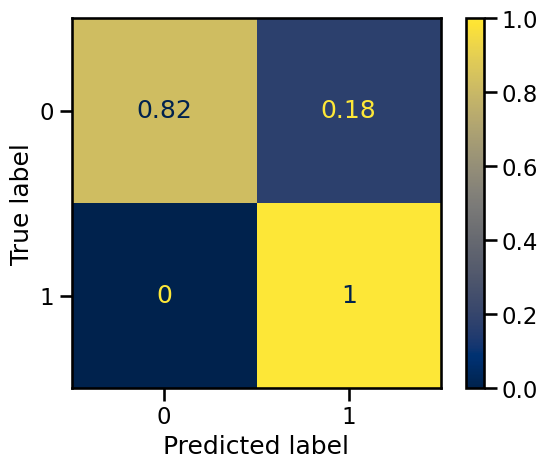

In [98]:
lr.fit(x_smo, y_smo)
lr_preds = lr.predict(x_test)

accuracy = accuracy_score(y_test, lr_preds)
precision, recall, f_beta, support = precision_recall_fscore_support(y_test, lr_preds, beta = 1, pos_label = 1, average = 'binary')
auc = roc_auc_score(y_test, lr_preds)
print('Logistic regression (SMOTE) results: \
Accuracy = {:.3f}, Precision = {:.3f}, Recall = {:.3f}, F score = {:.3f}, AUC = {:.3f}.'.format(accuracy, precision, recall, f_beta, auc))

sns.set_context('talk')
ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test, lr_preds, normalize = 'true'),
                       display_labels = lr.classes_).plot(cmap = 'cividis')
#plt.savefig('confusion_lr_SMOTE.pdf', dpi = 200, bbox_inches = 'tight', pad_inches = 0.0)
plt.show()

new_index = len(table1)
table1.loc[new_index] = ['SMOTE', accuracy, precision, recall, f_beta, auc]

Logistic regression (undersampling) results: Accuracy = 0.546, Precision = 0.205, Recall = 1.000, F score = 0.340, AUC = 0.743.


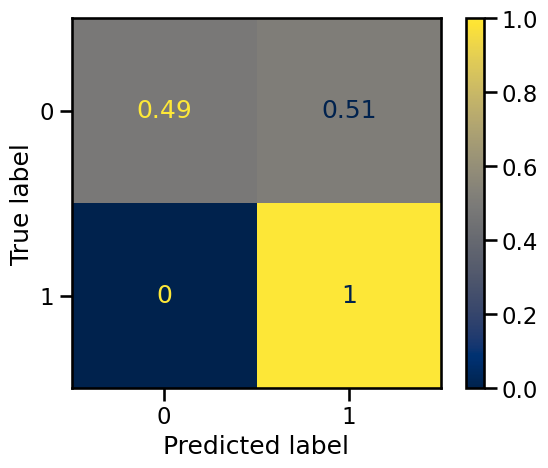

In [100]:
lr.fit(x_und, y_und)
lr_preds = lr.predict(x_test)

accuracy = accuracy_score(y_test, lr_preds)
precision, recall, f_beta, support = precision_recall_fscore_support(y_test, lr_preds, beta = 1, pos_label = 1, average = 'binary')
auc = roc_auc_score(y_test, lr_preds)
print('Logistic regression (undersampling) results: \
Accuracy = {:.3f}, Precision = {:.3f}, Recall = {:.3f}, F score = {:.3f}, AUC = {:.3f}.'.format(accuracy, precision, recall, f_beta, auc))

sns.set_context('talk')
ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test, lr_preds, normalize = 'true'),
                       display_labels = lr.classes_).plot(cmap = 'cividis')
#plt.savefig('confusion_lr_undersample.pdf', dpi = 200, bbox_inches = 'tight', pad_inches = 0.0)
plt.show()

new_index = len(table1)
table1.loc[new_index] = ['Undersampling', accuracy, precision, recall, f_beta, auc]

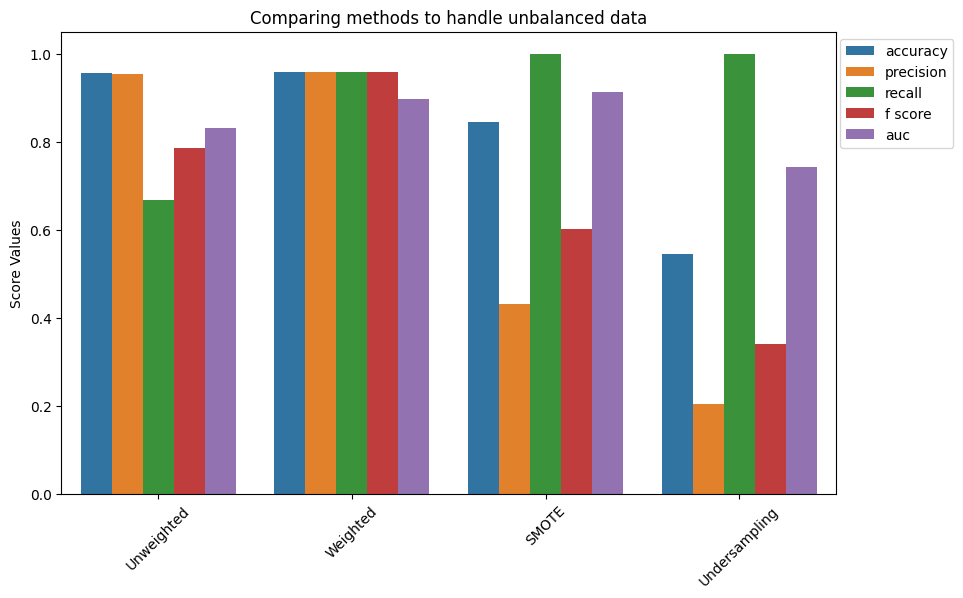

In [23]:
table1_melted = table1.melt(id_vars = 'model', var_name = 'Metric', value_name = 'Score')
plt.figure(figsize = (10, 6))
plt.title('Comparing methods to handle unbalanced data')
sns.barplot(x = 'model', y = 'Score', hue = 'Metric', data = table1_melted)
plt.xlabel('')
plt.ylabel('Score Values')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.16, 1), loc = 'upper right')
#plt.savefig('scores_balance.pdf', dpi = 200, bbox_inches = 'tight', pad_inches = 0.0)
plt.show()

## 3. Build and compare models

### 3.2 Classifier: logistic regression

In [24]:
lr = LogisticRegression(random_state = rs)
lr.get_params().keys()

dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'l1_ratio', 'max_iter', 'multi_class', 'n_jobs', 'penalty', 'random_state', 'solver', 'tol', 'verbose', 'warm_start'])

In [25]:
params_grid = {'penalty': ['l1', 'l2'],
               'solver': ['saga', 'lbfgs'],
               'max_iter': [500, 1000, 2000],
               'class_weight': [{0: 0.2, 1: 0.7},
                                {0: 0.2, 1: 0.9},
                                {0: 0.3, 1: 0.7},
                                {0: 0.3, 1: 0.9}]
              }

grid_search = GridSearchCV(estimator = lr, 
                           param_grid = params_grid, 
                           scoring = 'f1_weighted',
                           cv = 5,
                           verbose = 1)

grid_search.fit(x_train, y_train)
best_params = grid_search.best_params_
best_params

Fitting 5 folds for each of 48 candidates, totalling 240 fits


{'class_weight': {0: 0.2, 1: 0.7},
 'max_iter': 500,
 'penalty': 'l1',
 'solver': 'saga'}

In [26]:
l1l2_model = LogisticRegression(random_state = rs,
                                penalty = best_params['penalty'],
                                multi_class = 'auto',
                                solver = best_params['solver'],
                                max_iter = best_params['max_iter'],
                                class_weight = best_params['class_weight'])
l1l2_model.fit(x_train, y_train)
preds = l1l2_model.predict(x_test)

accuracy = accuracy_score(y_test, preds)
precision, recall, f_beta, support = precision_recall_fscore_support(y_test, preds, beta = 5, pos_label = 1, average = 'weighted')
auc = roc_auc_score(y_test, preds)
print('Logistic regression (l1 weighted) results: \
Accuracy = {:.3f}, Precision = {:.3f}, Recall = {:.3f}, F score = {:.3f}, AUC = {:.3f}.'.format(accuracy, precision, recall, f_beta, auc))

table2_data = [['Logistic regression (l1 re-weighted)', accuracy, precision, recall, f_beta, auc]]
table2 = pd.DataFrame(table2_data, columns = ['model', 'accuracy', 'precision', 'recall', 'f score', 'auc'])

Logistic regression (l1 weighted) results: Accuracy = 0.960, Precision = 0.960, Recall = 0.960, F score = 0.960, AUC = 0.907.


In [27]:
params_grid = {'penalty': ['elasticnet'],
               'solver': ['saga', 'lbfgs'],
               'max_iter': [500, 1000, 2000],
               'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9],
               'class_weight': [{0: 0.2, 1: 0.7},
                                {0: 0.2, 1: 0.9},
                                {0: 0.3, 1: 0.7},
                                {0: 0.3, 1: 0.9}]
              }

grid_search = GridSearchCV(estimator = l1l2_model, 
                           param_grid = params_grid, 
                           scoring = 'f1_weighted',
                           cv = 5,
                           verbose = 1)

grid_search.fit(x_train, y_train)
best_params = grid_search.best_params_
best_params

Fitting 5 folds for each of 120 candidates, totalling 600 fits


{'class_weight': {0: 0.3, 1: 0.9},
 'l1_ratio': 0.7,
 'max_iter': 500,
 'penalty': 'elasticnet',
 'solver': 'saga'}

In [28]:
ela_model = LogisticRegression(random_state = rs, 
                               penalty = 'elasticnet', 
                               multi_class = 'auto', 
                               solver = best_params['solver'], 
                               max_iter = best_params['max_iter'], 
                               l1_ratio = best_params['l1_ratio'],
                               class_weight = best_params['class_weight']
                              )
ela_model.fit(x_train, y_train)
preds = ela_model.predict(x_test)

accuracy = accuracy_score(y_test, preds)
precision, recall, f_beta, support = precision_recall_fscore_support(y_test, preds, beta = 5, pos_label = 1, average = 'weighted')
auc = roc_auc_score(y_test, preds)
print('Logistic regression (elastic-net re-weighted) results: \
Accuracy = {:.3f}, Precision = {:.3f}, Recall = {:.3f}, F score = {:.3f}, AUC = {:.3f}.'.format(accuracy, precision, recall, f_beta, auc))

new_index = len(table2)
table2.loc[new_index] = ['Logistic regression (elastic-net re-weighted)', accuracy, precision, recall, f_beta, auc]

Logistic regression (elastic-net re-weighted) results: Accuracy = 0.962, Precision = 0.962, Recall = 0.962, F score = 0.962, AUC = 0.899.


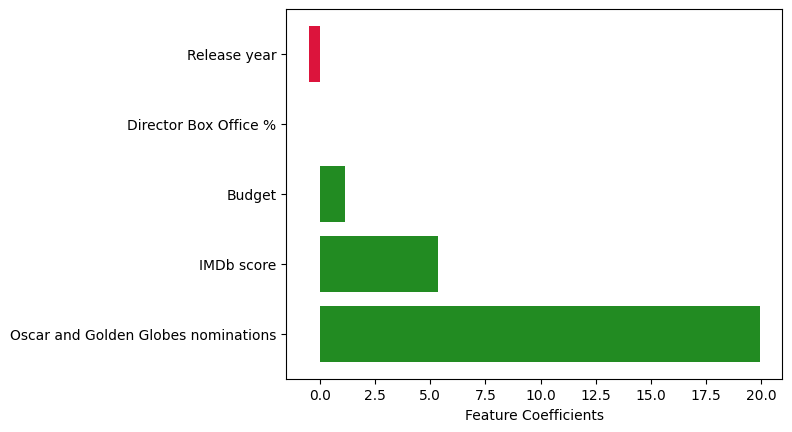

In [29]:
# Extract and sort feature coefficients
def get_feature_coefs(regression_model, label_index, columns):
    coef_dict = {}
    for coef, feat in zip(regression_model.coef_[label_index, :], columns):
        if abs(coef) >= 1e-10:
            coef_dict[feat] = coef
    # Sort coefficients
    coef_dict = {k: v for k, v in sorted(coef_dict.items(), key=lambda item: item[1])}
    return coef_dict

# Generate bar colors based on if value is negative or positive
def get_bar_colors(values):
    color_vals = []
    for val in values:
        if val <= 0:
            color_vals.append('crimson')
        else:
            color_vals.append('forestgreen')
    return color_vals

# Visualize coefficients
def visualize_coefs(coef_dict):
    features = list(coef_dict.keys())
    values = list(coef_dict.values())
    y_pos = np.arange(len(features))
    color_vals = get_bar_colors(values)
    plt.rcdefaults()
    fig, ax = plt.subplots()
    ax.barh(y_pos, values, align='center', color=color_vals)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(features)
    # labels read top-to-bottom
    ax.invert_yaxis()  
    ax.set_xlabel('Feature Coefficients')
    ax.set_title('')
    #plt.savefig('lr_coefficients.pdf', dpi = 200, bbox_inches = 'tight', pad_inches = 0.0)
    plt.show()
    
coef_dict = get_feature_coefs(l1l2_model, 0, feature_column)
visualize_coefs(coef_dict)

### 3.3 Classifier: SVM

In [66]:
svm = SVC()
params_grid = {'C': [1, 10, 100], 
               'kernel': ['poly', 'rbf', 'sigmoid'],
               'class_weight': [{0: 0.2, 1: 0.7},
                                {0: 0.2, 1: 0.9},
                                {0: 0.3, 1: 0.7},
                                {0: 0.3, 1: 0.9}]
              }

grid_search = GridSearchCV(estimator = svm, 
                           param_grid = params_grid, 
                           scoring = 'f1_weighted',
                           cv = 5, 
                           verbose = 1)

grid_search.fit(x_train, y_train)
best_params = grid_search.best_params_
best_params

Fitting 5 folds for each of 36 candidates, totalling 180 fits


{'C': 1, 'class_weight': {0: 0.2, 1: 0.7}, 'kernel': 'rbf'}

In [67]:
svm = SVC(C = best_params['C'], 
          kernel = best_params['kernel'],
          class_weight = best_params['class_weight'])
svm.fit(x_train, y_train)
preds = svm.predict(x_test)

accuracy = accuracy_score(y_test, preds)
precision, recall, f_beta, support = precision_recall_fscore_support(y_test, preds, beta = 5, pos_label = 1, average = 'weighted')
auc = roc_auc_score(y_test, preds)
print('SVM results: \
Accuracy = {:.3f}, Precision = {:.3f}, Recall = {:.3f}, F score = {:.3f}, AUC = {:.3f}.'.format(accuracy, precision, recall, f_beta, auc))

new_index = len(table2)
table2.loc[new_index] = ['SVM (re-weighted)', accuracy, precision, recall, f_beta, auc]

SVM results: Accuracy = 0.965, Precision = 0.965, Recall = 0.965, F score = 0.965, AUC = 0.915.


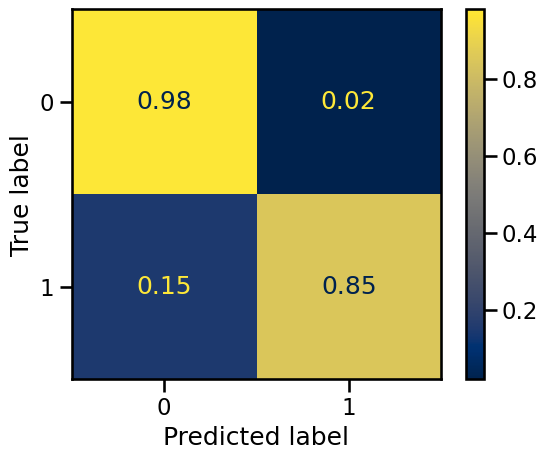

In [74]:
sns.set_context('talk')
ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test, preds, normalize = 'true'), display_labels = svm.classes_).plot(cmap = 'cividis')
#plt.savefig('confusion_svm_reweight.pdf', dpi = 200, bbox_inches = 'tight', pad_inches = 0.0)
plt.show()

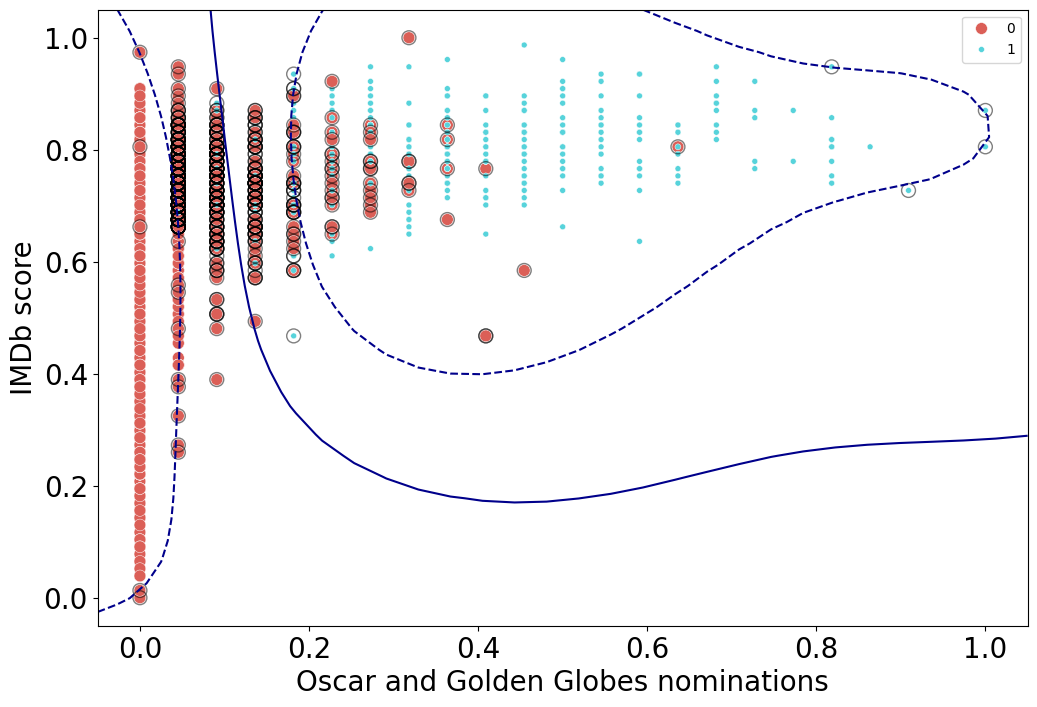

In [32]:
def plot_decision_boundry(X, y, model, xylabel):
    plt.figure(figsize = (12, 8))
    sns.scatterplot(x = X[:, 0], y = X[:, 1], hue = y, size = y, palette = 'hls')
    # plot the decision function
    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    # create grid to evaluate model
    xx = np.linspace(xlim[0], xlim[1], 30)
    yy = np.linspace(ylim[0], ylim[1], 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T
    Z = model.decision_function(xy).reshape(XX.shape)
    # plot decision boundary and margins
    ax.contour(XX, YY, Z, colors = 'darkblue', levels = [-1, 0, 1], alpha = 1, linestyles=["--", "-", "--"])
    # plot support vectors
    ax.scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1],
               s = 100,
               alpha = 0.5,
               linewidth = 1,
               facecolors = 'none',
               edgecolors = 'black')
    plt.xticks(fontsize = 20)
    plt.yticks(fontsize = 20)
    plt.xlabel(xylabel[0], fontsize = 20)
    plt.ylabel(xylabel[1], fontsize = 20)
    #plt.savefig('svm_decision_boundary.pdf', dpi = 200, bbox_inches = 'tight', pad_inches = 0.0)
    plt.show()

select_feature1 = 'Oscar and Golden Globes nominations'
select_feature2 = 'IMDb score'
xylabel = [select_feature1, select_feature2]
x_simp = df[xylabel]
x_simp = MinMaxScaler().fit_transform(x_simp)
svc.fit(x_simp, y)
plot_decision_boundry(x_simp, y, svc, xylabel)

### 3.4 Classifier: decision tree

In [33]:
tree_model = DecisionTreeClassifier(random_state=rs)

params_grid = {'criterion': ['gini', 'entropy'],
               'max_depth': [5, 10, 15, 20],
               'min_samples_leaf': [2, 5, 10],
               'class_weight': [{0: 0.2, 1: 0.7},
                                {0: 0.2, 1: 0.9},
                                {0: 0.3, 1: 0.7},
                                {0: 0.3, 1: 0.9}]
              }

grid_search = GridSearchCV(estimator = tree_model, 
                           param_grid = params_grid, 
                           scoring = 'f1_weighted', 
                           cv = 5, 
                           verbose = 1)
grid_search.fit(x_train, y_train)
best_params = grid_search.best_params_
best_params

Fitting 5 folds for each of 96 candidates, totalling 480 fits


{'class_weight': {0: 0.3, 1: 0.7},
 'criterion': 'entropy',
 'max_depth': 5,
 'min_samples_leaf': 5}

In [34]:
tree_model = DecisionTreeClassifier(random_state = rs,
                                    criterion = best_params['criterion'], 
                                    max_depth = best_params['max_depth'], 
                                    min_samples_leaf = best_params['min_samples_leaf'],
                                    class_weight = best_params['class_weight'])
tree_model.fit(x_train, y_train)
preds = tree_model.predict(x_test)

accuracy = accuracy_score(y_test, preds)
precision, recall, f_beta, support = precision_recall_fscore_support(y_test, preds, beta = 5, pos_label = 1, average = 'weighted')
auc = roc_auc_score(y_test, preds)
print('Decision tree results: \
Accuracy = {:.3f}, Precision = {:.3f}, Recall = {:.3f}, F score = {:.3f}, AUC = {:.3f}.'.format(accuracy, precision, recall, f_beta, auc))

new_index = len(table2)
table2.loc[new_index] = ['Decision tree (re-weighted)', accuracy, precision, recall, f_beta, auc]

Decision tree results: Accuracy = 0.937, Precision = 0.947, Recall = 0.937, F score = 0.937, AUC = 0.908.


In [35]:
def plot_decision_tree(model, feature_names):
    plt.subplots(figsize = (85, 30), dpi = 200)
    tree.plot_tree(model, feature_names = feature_names, 
                   fontsize = 20,
                   precision = 2,
                   filled = True, 
                   proportion = True, 
                   rounded = True)
    #plt.savefig('tree.pdf', dpi = 200, bbox_inches = 'tight', pad_inches = 0.0)
    plt.show()
    
plot_decision_tree(tree_model, feature_names = feature_column)

### 3.5 Classifier: random forest

In [49]:
random_forest_model = RandomForestClassifier()
random_forest_model.get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'monotonic_cst', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [50]:
param_grid = {'n_estimators': [3*n+1 for n in range(15)],
              'max_depth': [3*n+1 for n in range(5)],
              'max_features': ['auto', 'sqrt', 'log2'],
              'min_samples_split': [5, 10],
              'class_weight': [{0: 0.2, 1: 0.7},
                               {0: 0.2, 1: 0.9},
                               {0: 0.3, 1: 0.7},
                               {0: 0.3, 1: 0.9}]
             }
grid_search = GridSearchCV(estimator = random_forest_model, 
                           param_grid = param_grid, 
                           scoring = 'f1_weighted', 
                           cv = 5, 
                           verbose = 1)
grid_search.fit(x_train, y_train)
best_params = grid_search.best_params_
best_params

Fitting 5 folds for each of 1800 candidates, totalling 9000 fits


{'class_weight': {0: 0.3, 1: 0.7},
 'max_depth': 13,
 'max_features': 'log2',
 'min_samples_split': 5,
 'n_estimators': 16}

In [51]:
random_forest_model = RandomForestClassifier(random_state = rs, 
                                             bootstrap = True,
                                             max_depth = best_params['max_depth'],
                                             max_features = best_params['max_features'],
                                             min_samples_split = best_params['min_samples_split'],
                                             n_estimators = best_params['n_estimators'],
                                             class_weight = best_params['class_weight'])

random_forest_model.fit(x_train, y_train)
preds = random_forest_model.predict(x_test)

accuracy = accuracy_score(y_test, preds)
precision, recall, f_beta, support = precision_recall_fscore_support(y_test, preds, beta = 5, pos_label = 1, average = 'weighted')
auc = roc_auc_score(y_test, preds)
print('Random forest results: \
Accuracy = {:.3f}, Precision = {:.3f}, Recall = {:.3f}, F score = {:.3f}, AUC = {:.3f}.'.format(accuracy, precision, recall, f_beta, auc))

new_index = len(table2)
table2.loc[new_index] = ['Random forest (re-weighted)', accuracy, precision, recall, f_beta, auc]

Random forest results: Accuracy = 0.962, Precision = 0.961, Recall = 0.962, F score = 0.962, AUC = 0.890.


In [56]:
def get_correlation(X_test, y_test,models):
    #This function calculates the average correlation between predictors  
    n_estimators=len(models.estimators_)
    prediction=np.zeros((y_test.shape[0],n_estimators))
    predictions=pd.DataFrame({'estimator '+str(n+1):[] for n in range(n_estimators)})
    
    for key,model in zip(predictions.keys(),models.estimators_):
        predictions[key]=model.predict(X_test)
    
    corr=predictions.corr()
    print("Average correlation between predictors: ", corr.mean().mean()-1/n_estimators)
    #plt.savefig('random_forest_estimators.pdf', dpi = 200, bbox_inches = 'tight', pad_inches = 0.0)
    return corr

get_correlation(x_test, y_test, random_forest_model).style.background_gradient(cmap = 'coolwarm')

Average correlation between predictors:  0.5649569373072804


,estimator 1,estimator 2,estimator 3,estimator 4,estimator 5,estimator 6,estimator 7,estimator 8,estimator 9,estimator 10,estimator 11,estimator 12,estimator 13,estimator 14,estimator 15,estimator 16
estimator 1,1.000000,0.714090,0.621097,0.677356,0.644803,0.703773,0.653045,0.525535,0.597391,0.655747,0.658961,0.612724,0.605592,0.676850,0.738790,0.674596
estimator 2,0.714090,1.000000,0.603734,0.689821,0.603734,0.652611,0.703489,0.491258,0.654116,0.648623,0.709099,0.610381,0.639102,0.666802,0.727838,0.689659
estimator 3,0.621097,0.603734,1.000000,0.586889,0.548266,0.616799,0.548661,0.459721,0.586986,0.589196,0.587773,0.495568,0.561925,0.603740,0.614426,0.603938
estimator 4,0.677356,0.689821,0.586889,1.000000,0.561455,0.614874,0.666030,0.423641,0.599605,0.611054,0.562607,0.569977,0.611080,0.602705,0.646401,0.578507
estimator 5,0.644803,0.603734,0.548266,0.561455,1.000000,0.580952,0.644648,0.459721,0.561173,0.601096,0.612179,0.545482,0.561925,0.665848,0.614426,0.591681
estimator 6,0.703773,0.652611,0.616799,0.614874,0.580952,1.000000,0.605678,0.485368,0.545104,0.619903,0.633224,0.597318,0.578398,0.650586,0.661684,0.637474
estimator 7,0.653045,0.703489,0.548661,0.666030,0.644648,0.605678,1.000000,0.488704,0.572658,0.634979,0.693964,0.577947,0.628759,0.666191,0.655109,0.607322
estimator 8,0.525535,0.491258,0.459721,0.423641,0.459721,0.485368,0.488704,1.000000,0.510588,0.505525,0.562607,0.459322,0.450503,0.468078,0.508952,0.469823
estimator 9,0.597391,0.654116,0.586986,0.599605,0.561173,0.545104,0.572658,0.510588,1.000000,0.577295,0.575570,0.570440,0.511778,0.628583,0.672552,0.542656
estimator 10,0.655747,0.648623,0.589196,0.611054,0.601096,0.619903,0.634979,0.505525,0.577295,1.000000,0.640509,0.582031,0.574702,0.623674,0.657506,0.656100


## 4. Model comparison

In [57]:
table2

,model,accuracy,precision,recall,f score,auc
0,Logistic regression (l1 re-weighted),0.959748,0.960145,0.959748,0.959762,0.907247
1,Logistic regression (elastic-net re-weighted),0.962264,0.961650,0.962264,0.962233,0.899343
2,SVM (re-weighted),0.964780,0.964780,0.964780,0.964780,0.914760
3,Decision tree (re-weighted),0.937107,0.946970,0.937107,0.937214,0.908418
4,Random forest (re-weighted),0.962264,0.961231,0.962264,0.962192,0.890015


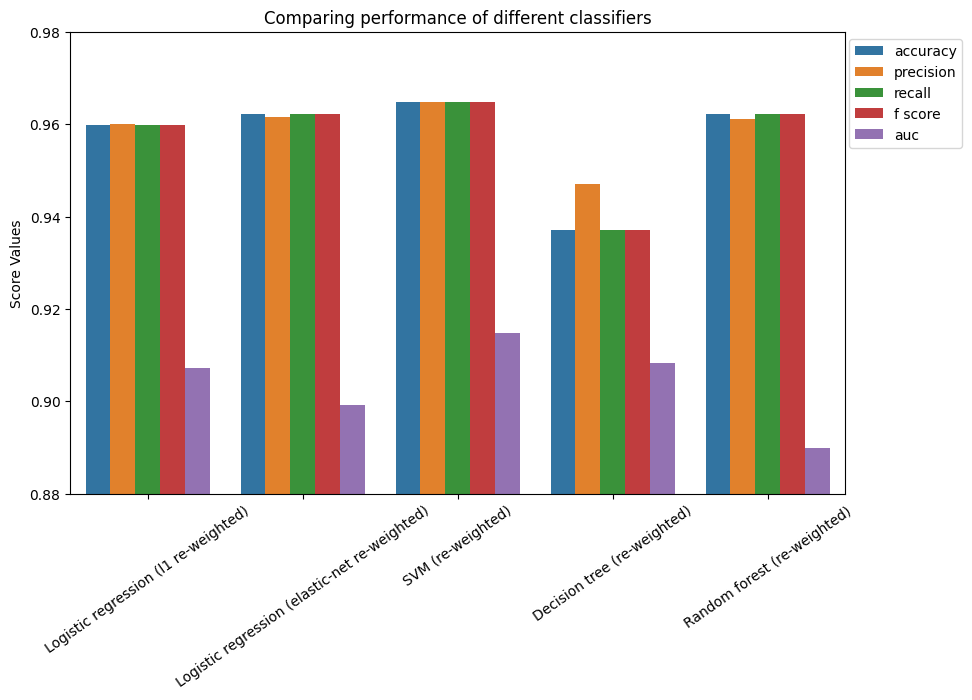

In [60]:
table2_melted = table2.melt(id_vars = 'model', var_name = 'Metric', value_name = 'Score')
plt.figure(figsize = (10, 6))
plt.title('Comparing performance of different classifiers')
sns.barplot(x = 'model', y = 'Score', hue = 'Metric', data = table2_melted)
plt.ylim(0.88, 0.98)
plt.xlabel('')
plt.ylabel('Score Values')
plt.xticks(rotation=35)
plt.legend(bbox_to_anchor=(1.16, 1), loc = 'upper right')
#plt.savefig('scores_models.pdf', dpi = 200, bbox_inches = 'tight', pad_inches = 0.0)
plt.show()

## 4. Outlooks